In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colors
from matplotlib import cm

from scipy import stats
from scipy.stats import multivariate_normal

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import seaborn as sns; sns.set()
np.random.seed(42)

In [2]:
# Génère les données 2D
def dataset(n,mu,C):
    dim = 2
    if len(n) == 2:
        # Deux nuages de points
        X0 = np.random.multivariate_normal(mu[0], C[0], n[0])        
        X = np.random.multivariate_normal(mu[1], C[1], n[1])
        X = np.r_[X0, X]
        y = np.hstack((np.zeros(n[0]), np.ones(n[1])))
    else:
        # Trois nuages de points
        X0 = np.random.multivariate_normal(mu[0], C[0], n[0])
        X1 = np.random.multivariate_normal(mu[1], C[1], n[1])
        X = np.random.multivariate_normal(mu[2], C[2], n[2])
        X = np.r_[X0, X1, X]
        y = np.hstack((np.zeros(n[0]), np.ones(n[1]), np.ones(n[2])*2))
        
    return X, y


In [3]:
# Génération des données au moyen d'une somme de distributions gaussiennes anisotropes

# --------- Cas avec 2 nuages de points avec faible recouvrement: paramètres des gaussiennes
mu2_1 = np.zeros((2,2))
mu2_1[0,:] = [-1., -1.]
mu2_1[1,:] = [1., 0.]

cov2_1 = np.zeros((2,2,2))
cov2_1[0,:,:] = [[.5, 0.], [0., .75]]
cov2_1[1,:,:] = [[1.5, -.5], [-.5, 1.]]

# Génération du dataset
r0, r1 = 0.6, 0.4
n_pts = 100
n0 = int(r0*n_pts)
n1 = int(r1*n_pts)
npts2 = np.array([n0, n1])

dataset2_1 = dataset(npts2,mu2_1,cov2_1)


# ------------- Cas avec 2 nuages de points se croisant: paramètres des gaussiennes
mu2_2 = np.zeros((2,2))
mu2_2[0,:] = [-1., -1.]
mu2_2[1,:] = [1., 0.]

cov2_2 = np.zeros((2,2,2))
cov2_2[0,:,:] = [[7., 0.9], [0.9, .2]]
cov2_2[1,:,:] = [[1.5, -.5], [-.5, 1.]]

# Génération du dataset
r0, r1 = 0.6, 0.4
n_pts = 100
n0 = int(r0*n_pts)
n1 = int(r1*n_pts)
npts2 = np.array([n0, n1])

dataset2_2 = dataset(npts2,mu2_2,cov2_2)


# ------------ Cas avec 3 nuages de points: paramètres des gaussiennes
mu3 = np.zeros((3,2))

mu3[0,:] = [0., 2.]
mu3[1,:] = [0., 6.]
mu3[2,:] = [5., 4.]

cov3 = np.zeros((3,2,2))
cov3[0,:,:] = [[2., 0.], [0., 1.]]
cov3[1,:,:] = [[1., 0.], [0., 1.]]
cov3[2,:,:] = [[1., 0.8], [0.8, 1.5]]

# Génération du dataset
r0, r1, r2 = 0.4, 0.3, 0.3
n_pts = 100
n0 = int(r0*n_pts)
n1 = int(r1*n_pts)
n2 = int(r2*n_pts)
npts3 = np.array([n0, n1, n2])

dataset3 = dataset(npts3,mu3,cov3)

In [4]:
# Fonction d'affichage des distributions de probabilités et des zones d'influence 

cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.5, 0.5)],
     'green': [(0, 0.5, 0.5), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)


# Cas à 2 distributions binormales de probabilités
def plot_dataset_2(lda, X, y, y_pred, xx, yy, ax):

    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # classe 0 en rouge (données bien classifiées '.', mal classifiées 'x')
    ax.scatter(X0_tp[:, 0], X0_tp[:, 1], marker='.', color='red')
    ax.scatter(X0_fp[:, 0], X0_fp[:, 1], marker='x', s=20, color='#990000')

    # classe 1 en bleu (idem)
    ax.scatter(X1_tp[:, 0], X1_tp[:, 1], marker='.', color='blue')
    ax.scatter(X1_fp[:, 0], X1_fp[:, 1], marker='x', s=20, color='#000099')


    # Identifie la zone d'influence de chaque classe.
    Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
        
    ax.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
            norm=colors.Normalize(0., 1.), zorder=0) 

    # Affiche la frontière délimitant la zone d'influence
    ax.contour(xx, yy, Z, [0.5], linewidths=2., colors='white')    

    
# Cas à 3 distributions binormales de probabilités
def plot_dataset_3(lda, X, y, y_pred, xx, yy, ax):

    tp = (y == y_pred)  # True Positive
    tp0, tp1, tp2 = tp[y == 0], tp[y == 1], tp[y == 2]
    X0, X1, X2 = X[y == 0], X[y == 1], X[y == 2]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]
    X2_tp, X2_fp = X2[tp2], X2[~tp2]

    # classe 0 en rouge (bien classifiées '.', mal classifiées 'x')
    ax.scatter(X0_tp[:, 0], X0_tp[:, 1], marker='.', color='red')
    ax.scatter(X0_fp[:, 0], X0_fp[:, 1], marker='x',
                s=20, color='#990000')  # dark red

    # classe 1 en bleu (idem)
    ax.scatter(X1_tp[:, 0], X1_tp[:, 1], marker='.', color='blue')
    ax.scatter(X1_fp[:, 0], X1_fp[:, 1], marker='x',
                s=20, color='#000099')  # dark blue

    # classe 2 en noir (idem)
    ax.scatter(X2_tp[:, 0], X2_tp[:, 1], marker='.', color='black')
    ax.scatter(X2_fp[:, 0], X2_fp[:, 1], marker='x',
                s=20, color='#000000')  # black

    # Identifie la zone d'influence de chaque classe.
    Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
        
    ax.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
            norm=colors.Normalize(0., 2.), zorder=0) 

    # Affiche les frontières délimitant les zones d'influence
    ax.contour(xx, yy, Z, [0.5, 1.5], linewidths=2., colors='white')    
  

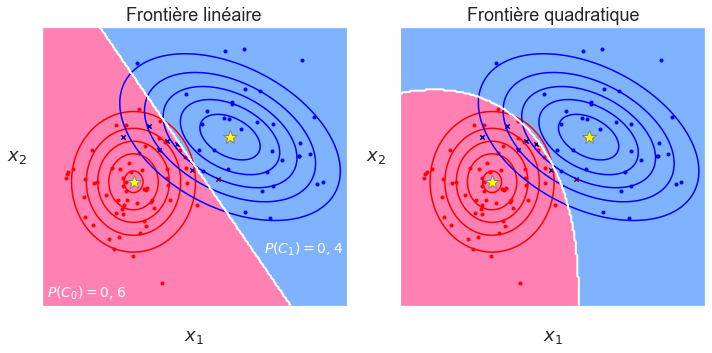

In [5]:
# Affiche les résultats de classification du dataset contenant 2 nuages de points avec faible recouvrement
(X, y) = dataset2_1

x_min = np.min(X[:,0]) - 0.5
x_max = np.max(X[:,0]) + 0.5
y_min = np.min(X[:,1]) - 0.5
y_max = np.max(X[:,1]) + 0.5

nx, ny = 200, 200
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
pos = np.dstack((xx, yy))




fig, ax = plt.subplots(1,2,figsize=(10,5), facecolor='white')

# Courbes de contours
rv = multivariate_normal(mu2_1[0,:],cov2_1[0,:,:])
ax[0].contour(xx, yy, rv.pdf(pos),levels=5,colors='red')
ax[1].contour(xx, yy, rv.pdf(pos),levels=5,colors='red')

rv = multivariate_normal(mu2_1[1,:],cov2_1[1,:,:])
ax[0].contour(xx, yy, rv.pdf(pos),levels=5,colors='blue')
ax[1].contour(xx, yy, rv.pdf(pos),levels=5,colors='blue')


# Position des centroides des distributions
ax[0].plot(mu2_1[0][0],mu2_1[0][1],'*', color='yellow', markersize=15, markeredgecolor='grey')
ax[0].plot(mu2_1[1][0],mu2_1[1][1],'*', color='yellow', markersize=15, markeredgecolor='grey')
ax[1].plot(mu2_1[0][0],mu2_1[0][1],'*', color='yellow', markersize=15, markeredgecolor='grey')
ax[1].plot(mu2_1[1][0],mu2_1[1][1],'*', color='yellow', markersize=15, markeredgecolor='grey')


# Courbes délimitant la zone d'influence de chaque distribution de probabilités normale
# Méthode I: Linear Discriminant Analysis 
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
y_pred = lda.fit(X, y).predict(X)
plot_dataset_2(lda, X, y, y_pred, xx, yy, ax[0])
ax[0].set_xlim(x_min, x_max)
ax[0].set_ylim(y_min, y_max)
ax[0].set_xticks(())
ax[0].set_yticks(())
ax[0].text(-2.8, -3.5, '$P(C_{0})=0,6$', horizontalalignment='left', verticalalignment='center', fontsize=14, color='white')
ax[0].text(1.7, -2.5, '$P(C_{1})=0,4$', horizontalalignment='left', verticalalignment='center', fontsize=14, color='white')
ax[0].set_xlabel('$x_{1}$',fontsize=18)
ax[0].set_ylabel('$x_{2}$',rotation=0,fontsize=18)
ax[0].xaxis.set_label_coords(0.5, -0.08)
ax[0].yaxis.set_label_coords(-0.08, 0.5)
ax[0].set_title("Frontière linéaire",fontsize=18)

# Méthode II: Quadratic Discriminant Analysis
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
y_pred = qda.fit(X, y).predict(X)
plot_dataset_2(qda, X, y, y_pred, xx, yy, ax[1])
ax[1].set_xlim(x_min, x_max)
ax[1].set_ylim(y_min, y_max)
ax[1].set_xticks(())
ax[1].set_yticks(())
ax[1].set_xlabel('$x_{1}$',fontsize=18)
ax[1].set_ylabel('$x_{2}$',rotation=0,fontsize=18)
ax[1].xaxis.set_label_coords(0.5, -0.08)
ax[1].yaxis.set_label_coords(-0.08, 0.5)
ax[1].set_title("Frontière quadratique",fontsize=18)

plt.tight_layout()
plt.subplots_adjust(top=0.92)

plt.savefig("Figure_26(1)_41.svg", format="svg")

plt.show()

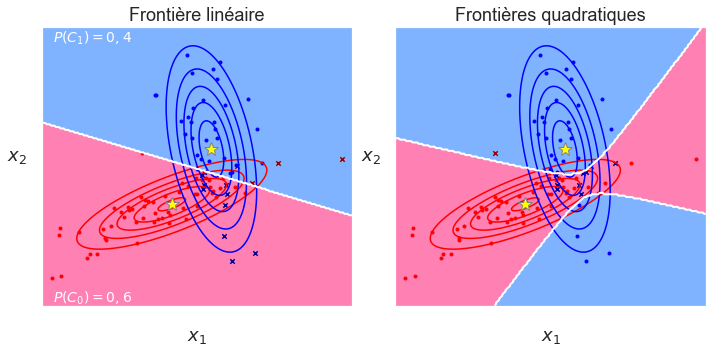

In [6]:
# Affiche les résultats de classification du dataset contenant 2 nuages de points se croisant
(X, y) = dataset2_2

x_min = np.min(X[:,0]) - 0.5
x_max = np.max(X[:,0]) + 0.5
y_min = np.min(X[:,1]) - 0.5
y_max = np.max(X[:,1]) + 0.5

nx, ny = 200, 200
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
pos = np.dstack((xx, yy))


#------------------------------------
fig, ax = plt.subplots(1,2,figsize=(10,5), facecolor='white')

# Courbes de contours
rv = multivariate_normal(mu2_2[0,:],cov2_2[0,:,:])
ax[0].contour(xx, yy, rv.pdf(pos),levels=5,colors='red')
ax[1].contour(xx, yy, rv.pdf(pos),levels=5,colors='red')

rv = multivariate_normal(mu2_2[1,:],cov2_2[1,:,:])
ax[0].contour(xx, yy, rv.pdf(pos),levels=5,colors='blue')
ax[1].contour(xx, yy, rv.pdf(pos),levels=5,colors='blue')


# Position des centroides des distributions
ax[0].plot(mu2_2[0][0],mu2_2[0][1],'*', color='yellow', markersize=15, markeredgecolor='grey')
ax[0].plot(mu2_2[1][0],mu2_2[1][1],'*', color='yellow', markersize=15, markeredgecolor='grey')
ax[1].plot(mu2_2[0][0],mu2_2[0][1],'*', color='yellow', markersize=15, markeredgecolor='grey')
ax[1].plot(mu2_2[1][0],mu2_2[1][1],'*', color='yellow', markersize=15, markeredgecolor='grey')


# Courbes délimitant la zone d'influence de chaque distribution de probabilités normale
# Méthode I: Linear Discriminant Analysis 
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
y_pred = lda.fit(X, y).predict(X)
plot_dataset_2(lda, X, y, y_pred, xx, yy, ax[0])
ax[0].set_xlim(x_min, x_max)
ax[0].set_ylim(y_min, y_max)
ax[0].set_xticks(())
ax[0].set_yticks(())
ax[0].text(-7., -2.7, '$P(C_{0})=0,6$', horizontalalignment='left', verticalalignment='center', fontsize=14, color='white')
ax[0].text(-7., 2., '$P(C_{1})=0,4$', horizontalalignment='left', verticalalignment='center', fontsize=14, color='white')
ax[0].set_xlabel('$x_{1}$',fontsize=18)
ax[0].set_ylabel('$x_{2}$',rotation=0,fontsize=18)
ax[0].xaxis.set_label_coords(0.5, -0.08)
ax[0].yaxis.set_label_coords(-0.08, 0.5)
ax[0].set_title("Frontière linéaire",fontsize=18)

# Méthode II: Quadratic Discriminant Analysis
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
y_pred = qda.fit(X, y).predict(X)
plot_dataset_2(qda, X, y, y_pred, xx, yy, ax[1])
ax[1].set_xlim(x_min, x_max)
ax[1].set_ylim(y_min, y_max)
ax[1].set_xticks(())
ax[1].set_yticks(())
ax[1].set_xlabel('$x_{1}$',fontsize=18)
ax[1].set_ylabel('$x_{2}$',rotation=0,fontsize=18)
ax[1].xaxis.set_label_coords(0.5, -0.08)
ax[1].yaxis.set_label_coords(-0.08, 0.5)
ax[1].set_title("Frontières quadratiques",fontsize=18)

plt.tight_layout()
plt.subplots_adjust(top=0.92)

plt.savefig("Figure_26(2)_41.svg", format="svg")

plt.show()

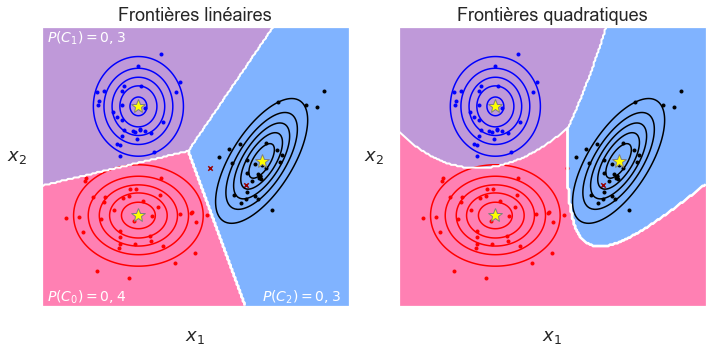

In [7]:
# Affiche les résultats de classification du dataset contenant 3 nuages de points
(X, y) = dataset3

x_min = np.min(X[:,0]) - 1.
x_max = np.max(X[:,0]) + 1.
y_min = np.min(X[:,1]) - 1.
y_max = np.max(X[:,1]) + 1.

nx, ny = 200, 200
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
pos = np.dstack((xx, yy))


#---------------------
fig, ax = plt.subplots(1,2,figsize=(10,5), facecolor='white')

# Courbes de contours
rv = multivariate_normal(mu3[0,:],cov3[0,:,:])
ax[0].contour(xx, yy, rv.pdf(pos),levels=5,colors='red')
ax[1].contour(xx, yy, rv.pdf(pos),levels=5,colors='red')

rv = multivariate_normal(mu3[1,:],cov3[1,:,:])
ax[0].contour(xx, yy, rv.pdf(pos),levels=5,colors='blue')
ax[1].contour(xx, yy, rv.pdf(pos),levels=5,colors='blue')

rv = multivariate_normal(mu3[2,:],cov3[2,:,:])
ax[0].contour(xx, yy, rv.pdf(pos),levels=5,colors='black')
ax[1].contour(xx, yy, rv.pdf(pos),levels=5,colors='black')

# Position des centroides des distributions
ax[0].plot(mu3[0][0],mu3[0][1],'*', color='yellow', markersize=15, markeredgecolor='grey')
ax[0].plot(mu3[1][0],mu3[1][1],'*', color='yellow', markersize=15, markeredgecolor='grey')
ax[0].plot(mu3[2][0],mu3[2][1],'*', color='yellow', markersize=15, markeredgecolor='grey')
ax[1].plot(mu3[0][0],mu3[0][1],'*', color='yellow', markersize=15, markeredgecolor='grey')
ax[1].plot(mu3[1][0],mu3[1][1],'*', color='yellow', markersize=15, markeredgecolor='grey')
ax[1].plot(mu3[2][0],mu3[2][1],'*', color='yellow', markersize=15, markeredgecolor='grey')

# Courbes délimitant la zone d'influence de chaque distribution de probabilités normale
# Méthode I: Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
y_pred = lda.fit(X, y).predict(X)
plot_dataset_3(lda, X, y, y_pred, xx, yy, ax[0])
ax[0].set_xlim(x_min, x_max)
ax[0].set_ylim(y_min, y_max)
ax[0].set_xticks(())
ax[0].set_yticks(())
ax[0].text(-3.7, -1., '$P(C_{0})=0,4$', horizontalalignment='left', verticalalignment='center', fontsize=14, color='white')
ax[0].text(-3.7, 8.5, '$P(C_{1})=0,3$', horizontalalignment='left', verticalalignment='center', fontsize=14, color='white')
ax[0].text(5., -1., '$P(C_{2})=0,3$', horizontalalignment='left', verticalalignment='center', fontsize=14, color='white')
ax[0].set_xlabel('$x_{1}$',fontsize=18)
ax[0].set_ylabel('$x_{2}$',rotation=0,fontsize=18)
ax[0].xaxis.set_label_coords(0.5, -0.08)
ax[0].yaxis.set_label_coords(-0.08, 0.5)
ax[0].set_title("Frontières linéaires",fontsize=18)

# Méthode II: Quadratic Discriminant Analysis
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
y_pred = qda.fit(X, y).predict(X)
plot_dataset_3(qda, X, y, y_pred, xx, yy, ax[1])
ax[1].set_xlim(x_min, x_max)
ax[1].set_ylim(y_min, y_max)
ax[1].set_xticks(())
ax[1].set_yticks(())
ax[1].set_xlabel('$x_{1}$',fontsize=18)
ax[1].set_ylabel('$x_{2}$',rotation=0,fontsize=18)
ax[1].xaxis.set_label_coords(0.5, -0.08)
ax[1].yaxis.set_label_coords(-0.08, 0.5)
ax[1].set_title("Frontières quadratiques",fontsize=18)

plt.tight_layout()
plt.subplots_adjust(top=0.92)

plt.savefig("Figure_27_41.svg", format="svg")

plt.show()